In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from package.Data import Dataset
from package.FeatureSelection import tStudent
import numpy as np
from scipy.stats import kurtosis, skew
from package.Kernels import DWT, Normalize, Dropna

In [6]:
dataset = Dataset.load(name='dataset')


dwt = DWT(wavelets =  ['db1','db6','db8','db10'], levels =  10, featureFunctions = 
    {
        'minabs' : lambda x: max(abs(x)),
        'min' : min,
        'minabs': lambda x: min(abs(x)),
        'std': np.std,
        'stdabs':  lambda x: np.std(abs(x)),
        'mean': np.mean,
        'meanabs' : lambda x: np.mean(abs(x)) ,
        'median' : np.median ,
        'medianabs' : lambda x: np.median(abs(x)),
        'kurt' : kurtosis,
        'kurtabs' : lambda x: kurtosis(abs(x)),
        'skew' : skew,
        'skewabs' : lambda x: skew(abs(x)),
        'zcr' : lambda x: (np.diff(np.sign(x)) != 0).sum() - (x == 0).sum(),
        'energy' : lambda x: np.sum(x.astype(float)**2),
    }
    )

dataset = dwt.fit(dataset)
dataset.save(name = 'dwtValeria')

100%|██████████| 1786/1786 [02:00<00:00, 14.82it/s]


In [7]:
datasetBase = Dataset.load(name='dwtValeria')

In [9]:
tstudent = tStudent(threshold = 0.8)
dataset = tstudent.fit(datasetBase)
norm = Normalize()
dataset = norm.fit(dataset)
dropna = Dropna()
dataset = dropna.fit(dataset)
dataset.save(name = 'tstudentValeria')
dataset


            Dataset
            X: (1786, 89)
            y: (1786, 1)
            classes: (1786, 5)
        

In [2]:
dataset = Dataset.load(name='tstudentValeria')

In [5]:
from package.Kernels import Normalize, Dropna
from package.Visualization import Visualization3D

dataset = tstudent.transform(datasetBase, threshold= 0.7)
norm = Normalize()
dataset = norm.fit(dataset)
dropna = Dropna()
dataset = dropna.fit(dataset)

vis = Visualization3D()
vis.plot(dataset, dataset.y)

NameError: name 'tstudent' is not defined

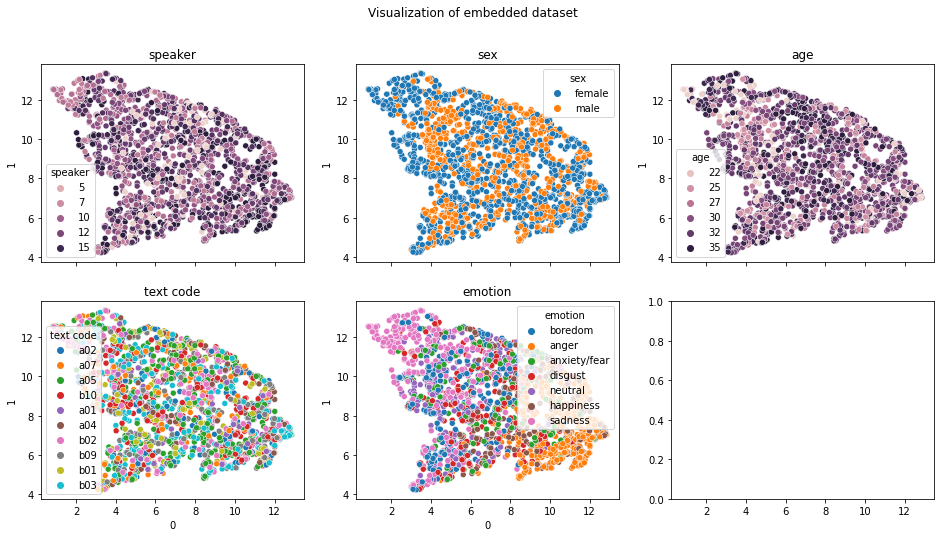

In [20]:
from package.Visualization import Visualization
from umap import UMAP
import matplotlib.pyplot as plt
# close all matplotlib figures
plt.close('all')

vis = Visualization(reductionAlgoritm = UMAP(n_components=2, n_neighbors=10, min_dist=0.2))
# baby plot

vis.plot(dataset)

# Supervised Learning

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from package.SupervisedLearning import ModelCompare

models = [
    #DecisionTreeClassifier(max_depth=5),
    #RandomForestClassifier(n_estimators=10, max_depth=5),
    MLPClassifier(hidden_layer_sizes=(50,), max_iter=10000),
    MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000),
    MLPClassifier(hidden_layer_sizes=(150,), max_iter=1000),
    MLPClassifier(hidden_layer_sizes=(100,), max_iter=5000)]

for model in models:
    X_train, X_test, y_train, y_test = dataset.split()
    model.fit(X_train, np.ravel(y_train))
    print(model.__class__.__name__ ,model.score(X_test, y_test))



MLPClassifier 0.547486033519553
MLPClassifier 0.5586592178770949
MLPClassifier 0.5810055865921788
MLPClassifier 0.5698324022346368


In [25]:
from skopt import BayesSearchCV
from sklearn.neural_network import MLPClassifier
from skopt.space import Real, Categorical, Integer

X_train, X_test, y_train, y_test = dataset.split()

# log-uniform: understand as search over p = exp(x) by varying x
opt = BayesSearchCV(
    MLPClassifier(hidden_layer_sizes=(50,50), max_iter=1000),
    {   
        'activation': Categorical(['tanh', 'relu']),
        #'solver': Categorical(['lbfgs', 'sgd', 'adam']),
        'alpha': Real(low=1e-5, high=1e-1, prior='log-uniform'),
        #'learning_rate': Categorical(['constant', 'invscaling', 'adaptive']),
        'learning_rate_init': Real(low=1e-6, high=1e-2, prior='log-uniform'),
        #'power_t': Real(low=0.1, high=0.9, prior='log-uniform'),
    },
    n_iter=2**5,
    cv=3
)

opt.fit(X_train, np.ravel(y_train))

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))

/opt/anaconda3/envs/ser/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/envs/ser/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/envs/ser/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/envs/ser/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y t

array(['neutral', 'sadness', 'anxiety/fear', ..., 'boredom',
       'anxiety/fear', 'neutral'], dtype=object)